# Comparison among GD, Newton method and Richardson (Appoximate Newton) 

In [1]:
import numpy as np 
import torch
from torch.nn import Module
from torch.autograd import grad
import torchvision.datasets as datasets
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
np.random.seed(100)
torch.manual_seed(100)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
def hessian(grads, model):
    """
    Order: W first, then b
    """
    size = grads[0].shape[1] + 1  # +1 is for the bias
    hess = torch.zeros(size, size).to(device)
    i = 0
    for grad in grads[0].flatten():
        W_second = torch.autograd.grad(grad, model.parameters(), retain_graph=True)
        hess[i] = torch.cat([W_second[0], W_second[1].view(1, 1)], 1)
        i += 1
    b_second = torch.autograd.grad(grads[1], model.parameters(), retain_graph=True)
    hess[i] = torch.cat([b_second[0], b_second[1].view(1, 1)], 1)
    i += 1
    return hess

def newton_direction(grads, model):
    """
    Order: W first, then b
    """
    grads_as_vector = torch.cat([-grads[0].data.clone().detach(), -grads[1].clone().view(1, 1)], 1)
    hess = hessian(grads, model).to(device)
    inverse_hess = torch.inverse(hess).to(device)
    direction = torch.matmul(grads_as_vector, inverse_hess)
    weights_direction = direction[0, 0:-1].view(grads[0].shape).to(device)
    bias_direction = direction[0, -1].view(grads[1].shape).to(device)
    return [weights_direction, bias_direction]

def richardson_iter(grads, model, tol=1e-6):
    def hessian_max_min_eig(grads, model):
        hess = hessian(grads, model).to(device)
        eigvalues = torch.eig(hess)[0]
        real_eigvalues = [real for real, img in eigvalues if torch.abs(img) < 1e-6]
        return max(real_eigvalues), min(real_eigvalues)
    newton_direction = [torch.zeros_like(param.data) for param in model.parameters()]
    eigmax, eigmin = hessian_max_min_eig(grads, model)
    alpha = 2 / (eigmax + eigmin)
    num_iters = int(torch.ceil(((eigmax + eigmin) / (2 * eigmin)) * np.log(1/tol)))
    # print("alpha:", alpha)
    for it in range(1, num_iters + 1):
        model.zero_grad()
        Hv = torch.autograd.grad(grads, 
                                 model.parameters(), 
                                 grad_outputs=newton_direction, 
                                 create_graph=False, 
                                 retain_graph=True)
        for dt, hv, grad in zip(newton_direction, Hv, grads):
            dt.data = dt.data - alpha * hv - alpha * grad.data
    return newton_direction

def descent_direction(loss, model, mode="sgd"):
    """
    mode: eigther "sgd", "newton", or "richardson"
    """
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    mode = mode.lower()
    if mode not in ["sgd", "newton", "richardson"]:
        raise Exception("Undefined mode of direction. Must be either sgd or newton")
    if mode == "sgd":
        return [-grad.data.to(device) for grad in grads]
    elif mode == "newton":
        return newton_direction(grads, model)
    else:
        return richardson_iter(grads, model, tol=1e-6)

In [3]:
def plot(comparison, dataset="", filename=None):
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.plot(comparison["sgd"]["training_loss"], label="SGD")
    plt.plot(comparison["newton"]["training_loss"], label="True Newton")
    plt.plot(comparison["richardson"]["training_loss"], label="Richardson")
    plt.legend()
    plt.xlabel("Epoch", size=15)
    plt.ylabel("Training Loss", size=15)
    plt.subplot(133)
    plt.bar(["SGD"], comparison["sgd"]["training_time"])
    plt.bar(["Newton"], comparison["newton"]["training_time"])
    plt.bar(["Richardson"], comparison["richardson"]["training_time"])

    plt.ylabel("Training time (s)", size=15)
    plt.subplot(132)
    plt.plot(comparison["sgd"]["test_loss"], label="SGD")
    plt.plot(comparison["newton"]["test_loss"], label="True Newton")
    plt.plot(comparison["richardson"]["test_loss"], label="Richardson")
    plt.legend()
    plt.xlabel("Epoch", size=15)
    plt.ylabel("Test Loss", size=15)
    plt.suptitle("Convex Task: {} (d=100)".format(dataset), fontsize=16, y=0.0)
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    

# Model Comparison

In [4]:
def compare_models(model="linear_reg", modes=["sgd", "newton", "richardson"], 
                   lr=[0.03, 1., 1.], lamb=0.01, epochs=200, 
                   full_batch=True, verbose=False):
    if model == "linear_reg":
        loss_fn = nn.MSELoss(reduction="mean")
    else:
        loss_fn = nn.BCEWithLogitsLoss(reduction="mean")
    data = {}
    for i, mode in enumerate(modes):
        data[mode] = {"training_loss": [], "training_time": 0., "test_loss": []}
        LinearRegression = nn.Sequential(nn.Linear(100, 1)).to(device)
        for param in LinearRegression.parameters():
            if len(param.shape) >= 2:
                nn.init.xavier_uniform_(param)
        start = time.time()
        for epoch in range(1, epochs+1):
            LinearRegression.zero_grad()
            
            if full_batch:
                X_tr, y_tr = X_train, y_train
            else:
                X_tr, y_tr = get_next_batch(train=True)
            
            test_loss = loss_fn(LinearRegression(X_test.to(device)), y_test.to(device))
            data[mode]["test_loss"].append(test_loss.item())

            loss = loss_fn(LinearRegression(X_tr.to(device)), y_tr.to(device))

            for param in LinearRegression.parameters():
                loss += (lamb / 2) * torch.sum(param * param)
                
            directions = descent_direction(loss, LinearRegression, "newton")
            for param, direction in zip(LinearRegression.parameters(), directions):
                param.data.add_(lr[i] * direction)
            if verbose and epoch % 20 == 0:
              print("Epoch {:3d}: loss = {:.3f}".format(epoch, loss.item()))
            data[mode]["training_loss"].append(loss.item())
            
        data[mode]["training_time"] = time.time() - start

    return data

# Linear Regression

## Generate the data

In [163]:
def generate_linear_data(num_users=100, rho=10, dim=40, noise_ratio=0.05):
    # For consistent results
    np.random.seed(100)
    '''Helper function to generate data'''
    # generate power S
    powers = - np.log(rho) / np.log(dim) / 2
    DIM = np.arange(dim)

    # Covariance matrix for X
    S = np.power(DIM+1, powers)

    # Creat list data for all users 
    X_split = [[] for _ in range(num_users)]  # X for each user
    y_split = [[] for _ in range(num_users)]  # y for each user
    samples_per_user = np.random.lognormal(4, 2, num_users).astype(int) + 50
    indices_per_user = np.insert(samples_per_user.cumsum(), 0, 0, 0)
    num_total_samples = indices_per_user[-1]

    # Create mean of data for each user, each user will have different distribution
    mean_X = np.array([np.random.randn(dim) for _ in range(num_users)])


    X_total = np.zeros((num_total_samples, dim))
    y_total = np.zeros(num_total_samples)

    for n in range(num_users):
        # Generate data
        X_n = np.random.multivariate_normal(mean_X[n], np.diag(S), samples_per_user[n])
        X_total[indices_per_user[n]:indices_per_user[n+1], :] = X_n

    

    # Generate weights and labels
    W = np.random.rand(dim)
    y_total = X_total.dot(W)
    y_total = y_total + np.sqrt(noise_ratio) * np.random.randn(num_total_samples)

    for n in range(num_users):
        X_n = X_total[indices_per_user[n]:indices_per_user[n+1], :]
        y_n = y_total[indices_per_user[n]:indices_per_user[n+1]]
        X_split[n] = X_n
        y_split[n] = y_n

    # Normalize all X's using LAMBDA
    norm = max([np.linalg.norm(X_split[i].T.dot(X_split[i]), 2) / X_split[i].shape[0] for i in range(num_users)])
    # norm2 = np.sqrt(np.linalg.norm(X_total.T.dot(X_total), 2) / num_total_samples)
    # print(norm, norm2)
    X_total /= norm

    for n in range(num_users):
        X_split[n] /= norm
    
    return X_split, y_total
    
    # return X_total, y_total

X, y = generate_linear_data(dim=40, noise_ratio=0.4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train = torch.from_numpy(X_train).type(torch.float32).to(device)
y_train = torch.from_numpy(y_train).type(torch.float32).view(-1, 1).to(device)
X_test = torch.from_numpy(X_test).type(torch.float32).to(device)
y_test = torch.from_numpy(y_test).type(torch.float32).view(-1, 1).to(device)
train_set =  TensorDataset(X_train, y_train)
test_test = TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_test, batch_size=1000, shuffle=False)
iter_train_loader = iter(train_loader)
iter_test_loader = iter(test_loader)

def get_next_batch(train=True):
    iter_loader = iter_train_loader if train else iter_test_loader
    data_loader = train_loader if train else test_loader
    try:
        # Samples a new batch for persionalizing
        (X, y) = next(iter_loader)
    except StopIteration:
        # restart the generator if the previous generator is exhausted.
        iter_loader = iter(data_loader)
        (X, y) = next(iter_loader)
    return (X, y)

ValueError: Found input variables with inconsistent numbers of samples: [100, 26997]

In [170]:
x = X[4]
hess = x.T.dot(x) / x.shape[0] #+ 1. * np.eye(x.shape[1])
eigvals = np.linalg.eig(hess)[0]
eigmax = eigvals.max()
eigmin = eigvals.min()
print("max:", eigmax)
print("min:", eigmin)
print("kappa:", eigvals.max() / eigvals.min())

max: 6.989623778737231e-07
min: 3.058037758743261e-09
kappa: 228.56564667173058


In [139]:
tol = 0
hess_sum = None
for x in X:
    hess = x.T.dot(x) / x.shape[0] #+ 1. * np.eye(x.shape[1])
    # tol += x.shape[0]
    if hess_sum is None:
        hess_sum = hess
    else:
        hess_sum += hess
hess_sum /= 1000
# hess += + 1. * np.eye(x.shape[1])
eigvals = np.linalg.eig(hess_sum)[0]
eigmax = eigvals.max()
eigmin = eigvals.min()
print("max:", eigmax)
print("min:", eigmin)
print("kappa:", eigvals.max() / eigvals.min())
#tol.append(eigvals.max() / eigvals.min())
    

max: 0.1476458463952423
min: 0.057806649829318296
kappa: 2.5541325579528653


In [124]:
x = X[5]
hess = x.T.dot(x) / x.shape[0] + 1. * np.eye(x.shape[1])
eigvals = np.linalg.eig(hess)[0]
eigmax = eigvals.max()
eigmin = eigvals.min()
print("max:", eigmax)
print("min:", eigmin)
print("kappa:", eigvals.max() / eigvals.min())

max: 8.970123955783698
min: 1.002422145925956
kappa: 8.948449505270885


In [107]:
eigvals.max() / eigvals.min()

34.114360803478775

(array([ 7., 11., 23., 21., 21., 10.,  5.,  1.,  0.,  1.]),
 array([ 6.64598535+0.j,  7.18391187+0.j,  7.72183839+0.j,  8.25976492+0.j,
         8.79769144+0.j,  9.33561796+0.j,  9.87354448+0.j, 10.411471  +0.j,
        10.94939753+0.j, 11.48732405+0.j, 12.02525057+0.j]),
 <a list of 10 Patch objects>)

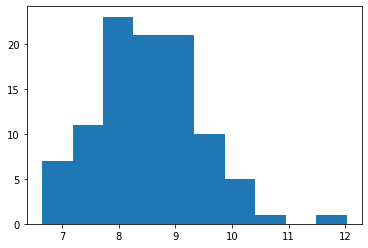

In [94]:
plt.hist(tol)

In [69]:
hess = X.T.dot(X) / X.shape[0] + 0.05 * np.eye(X.shape[1])
eigvals = np.linalg.eig(hess)[0]
eigmax = eigvals.max()
eigmin = eigvals.min()
eigvals.max() / eigvals.min()

13.86731157371123

In [62]:
eigvals.max() / eigvals.min()

1.9498543622931155

In [63]:
(eigmax + eigmin) / (eigmin + eigmin)

1.4749271811465576

## Generate data according to "Communication-Efficient Distributed Optimization in Networks with Gradient Tracking and Variance Reduction"

In [283]:
def generate_x(n_samples, dim, kappa, n_agent):
    '''Helper function to generate data''' 

    powers = - np.log(kappa) / np.log(dim) / 2

    S = np.power(np.arange(dim)+1, powers)
    X = np.random.randn(n_samples, dim) # Random standard Gaussian data
    X *= S                              # Conditioning
    # X_list = split_data(m, X)

    X_list = [X[i:i+100] for i in range(n_samples // n_agent)]
    max_norm = max([np.linalg.norm(X_list[i].T.dot(X_list[i]), 2) / X_list[i].shape[0] for i in range(n_agent)])
    X /= max_norm

    # L = 1, lambda = 1/kappa

    return X, 1, 1/kappa, np.diag(S)

In [284]:
X, L, lamb, co = generate_x(10000, 40, 1.2, 10)

In [285]:
kappas, eigmaxs, eigmins = [], [], []
for i in range(1000):
    X, L, lamb, co = generate_x(10000, 40, 4., 100)
    hess = X.T.dot(X) / X.shape[0] # + 0.05 * np.eye(X.shape[1])
    eigvals = np.linalg.eig(hess)[0]
    eigmax = eigvals.max()
    eigmin = eigvals.min()
    eigmaxs.append(eigmax)
    eigmins.append(eigmin)
    kappas.append(eigvals.max() / eigvals.min())
    # print("max:", eigmax)
    # print("min:", eigmin)
    # print("kappa:", eigvals.max() / eigvals.min())

(array([  2.,  26.,  73., 202., 223., 228., 150.,  68.,  20.,   8.]),
 array([3.93244319, 3.97874631, 4.02504944, 4.07135256, 4.11765569,
        4.16395881, 4.21026193, 4.25656506, 4.30286818, 4.34917131,
        4.39547443]),
 <a list of 10 Patch objects>)

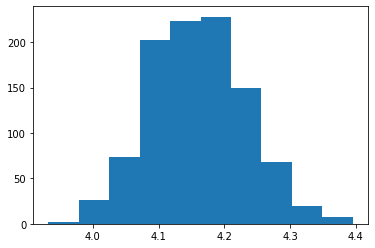

In [286]:
plt.hist(kappas)

(array([ 14.,  41.,  85., 205., 241., 215., 132.,  54.,  10.,   3.]),
 array([0.04063959, 0.04395456, 0.04726952, 0.05058448, 0.05389945,
        0.05721441, 0.06052937, 0.06384433, 0.0671593 , 0.07047426,
        0.07378922]),
 <a list of 10 Patch objects>)

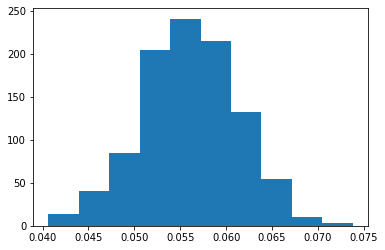

In [287]:
plt.hist(eigmaxs)

(array([ 22.,  49.,  97., 204., 246., 192., 130.,  47.,  10.,   3.]),
 array([0.00995398, 0.01073347, 0.01151296, 0.01229245, 0.01307194,
        0.01385143, 0.01463092, 0.01541042, 0.01618991, 0.0169694 ,
        0.01774889]),
 <a list of 10 Patch objects>)

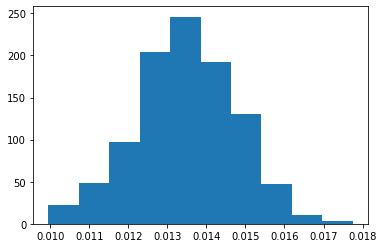

In [288]:
plt.hist(eigmins)

## Compare the models

In [6]:
comparison = compare_models(model="linear_reg", full_batch=True)

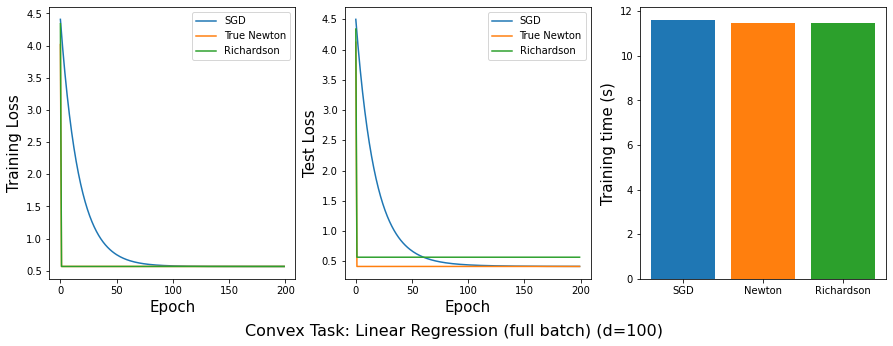

In [7]:
plot(comparison, "Linear Regression (full batch)", filename="linear_regression_full_batch.pdf")

In [8]:
comparison = compare_models(model="linear_reg", full_batch=False,
                            lr=[0.03, 0.1, 0.1])

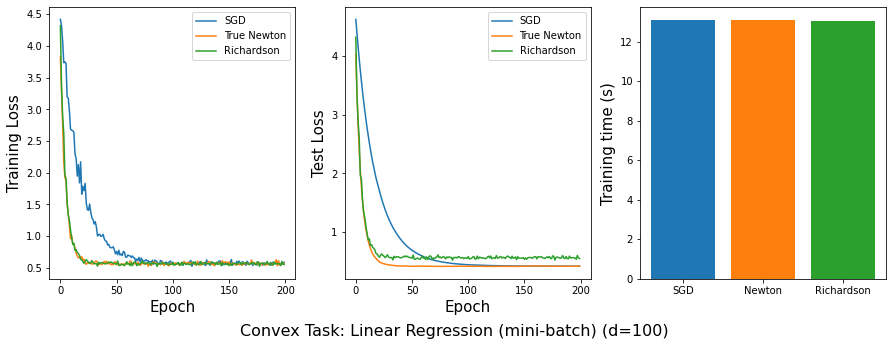

In [9]:
plot(comparison, "Linear Regression (mini-batch)", filename="linear_regression_mini_batch.pdf")

# Logistic Regression

## Generate the data

In [10]:
def generate_logistic_regression_data(num_users=100, rho=10, dim=40, 
                                      lamb=0.1, noise_ratio=0.05):
    def logit(X, W):
        return 1 / (1 + np.exp(-np.dot(X, W)))
    # For consistent results
    np.random.seed(100)

    # Sanity check
    assert(rho >= 1 and num_users > 0 and dim > 0)

    X_split = [[] for _ in range(num_users)]  # X for each user
    y_split = [[] for _ in range(num_users)]  # y for each user

    # Find users' sample sizes based on the power law (heterogeneity)
    samples_per_user = np.random.lognormal(4, 2, num_users).astype(int) + 50 + 10000
    indices_per_user = np.insert(samples_per_user.cumsum(), 0, 0, 0)
    num_total_samples = indices_per_user[-1]

    # Each user's mean is drawn from N(0, 1) (non-i.i.d. data)
    mean_X = np.random.randn(dim)

    # Covariance matrix for X
    Sigma = np.eye(dim)

    # L = 1, beta = LAMBDA
    #L = 100 if rho == 1 else 1 / (rho - 1)
    L = lamb/(rho - 1)
    # Keep all users' inputs and labels in one array,
    # indexed according to indices_per_user.
    #   (e.g. X_total[indices_per_user[n]:indices_per_user[n+1], :] = X_n)
    #   (e.g. y_total[indices_per_user[n]:indices_per_user[n+1]] = y_n)
    X_total = np.zeros((num_total_samples, dim))
    y_total = np.zeros(num_total_samples)

    for n in range(num_users):
        # Generate data
        X_n = np.random.multivariate_normal(mean_X, Sigma, samples_per_user[n])
        X_total[indices_per_user[n]:indices_per_user[n+1], :] = X_n

    # Normalize all X's using LAMBDA
    norm = np.sqrt(np.linalg.norm(X_total.T.dot(X_total), 2) / num_total_samples)
    X_total /= norm + L

    # Generate weights and labels
    W = np.random.rand(dim)
    y_total = logit(X_total, W)
    y_total = np.where(y_total > 0.5, 1, 0)

    # Apply noise: randomly flip some of y_n with probability noise_ratio
    noise = np.random.binomial(1, noise_ratio, num_total_samples)
    y_total = np.multiply(noise - y_total, noise) + np.multiply(y_total, 1 - noise)

    return X_total, y_total

X, y = generate_logistic_regression_data(dim=100, noise_ratio=0.4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train = torch.from_numpy(X_train).type(torch.float32).to(device)
y_train = torch.from_numpy(y_train).type(torch.float32).view(-1, 1).to(device)
X_test = torch.from_numpy(X_test).type(torch.float32).to(device)
y_test = torch.from_numpy(y_test).type(torch.float32).view(-1, 1).to(device)
train_set =  TensorDataset(X_train, y_train)
test_test = TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_test, batch_size=1000, shuffle=False)
iter_train_loader = iter(train_loader)
iter_test_loader = iter(test_loader)

def get_next_batch(train=True):
    iter_loader = iter_train_loader if train else iter_test_loader
    data_loader = train_loader if train else test_loader
    try:
        # Samples a new batch for persionalizing
        (X, y) = next(iter_loader)
    except StopIteration:
        # restart the generator if the previous generator is exhausted.
        iter_loader = iter(data_loader)
        (X, y) = next(iter_loader)
    return (X, y)

## Compare the models

In [11]:
comparison = compare_models(model="logistic_reg")

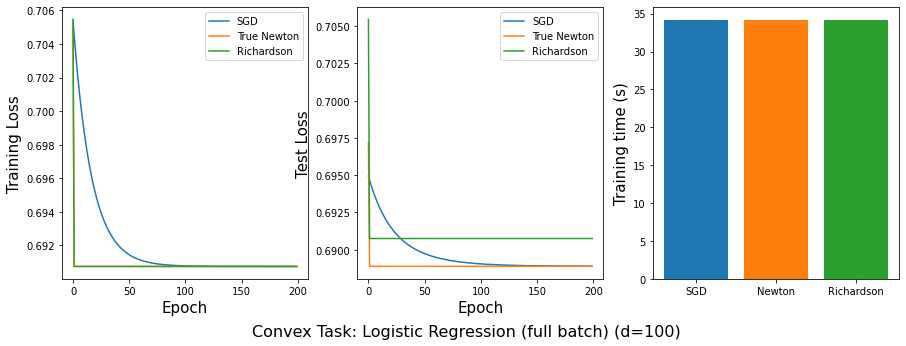

In [12]:
plot(comparison, dataset="Logistic Regression (full batch)", filename="logistic_regression_full_batch.pdf")

In [15]:
comparison = compare_models(model="logistic_reg", full_batch=False,
                            lr=[0.01, 0.1, 0.03])

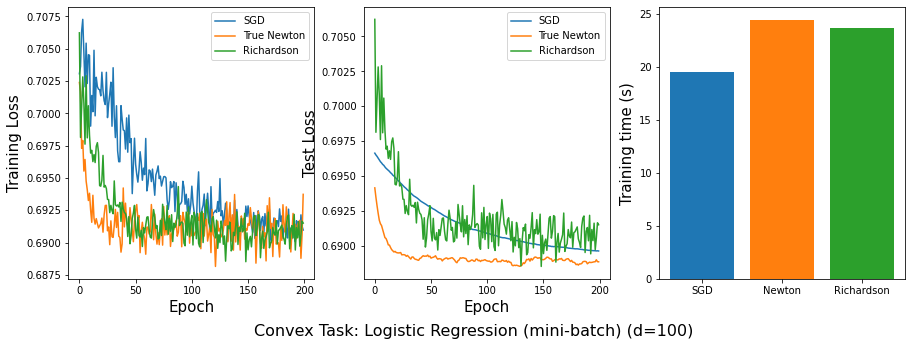

In [16]:
plot(comparison, dataset="Logistic Regression (mini-batch)", filename="logistic_regression_mini_batch.pdf")

# Richardson iteration

## Generate data

In [17]:
def generate_linear_data(num_users=100, rho=10, dim=40, noise_ratio=0.05):
    # For consistent results
    np.random.seed(100)
    '''Helper function to generate data'''
    # generate power S
    powers = - np.log(rho) / np.log(dim) / 2
    DIM = np.arange(dim)

    # Covariance matrix for X
    S = np.power(DIM+1, powers)

    # Creat list data for all users 
    X_split = [[] for _ in range(num_users)]  # X for each user
    y_split = [[] for _ in range(num_users)]  # y for each user
    samples_per_user = np.random.lognormal(4, 2, num_users).astype(int) + 50
    indices_per_user = np.insert(samples_per_user.cumsum(), 0, 0, 0)
    num_total_samples = indices_per_user[-1]

    # Create mean of data for each user, each user will have different distribution
    mean_X = np.array([np.random.randn(dim) for _ in range(num_users)])


    X_total = np.zeros((num_total_samples, dim))
    y_total = np.zeros(num_total_samples)

    for n in range(num_users):
        # Generate data
        X_n = np.random.multivariate_normal(mean_X[n], np.diag(S), samples_per_user[n])
        X_total[indices_per_user[n]:indices_per_user[n+1], :] = X_n

    # Normalize all X's using LAMBDA
    norm = np.sqrt(np.linalg.norm(X_total.T.dot(X_total), 2) / num_total_samples)
    X_total /= norm

    # Generate weights and labels
    W = np.random.rand(dim)
    y_total = X_total.dot(W)
    y_total = y_total + np.sqrt(noise_ratio) * np.random.randn(num_total_samples)
    
    return X_total, y_total

X, y = generate_linear_data(dim=100, noise_ratio=0.4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train = torch.from_numpy(X_train).type(torch.float32).to(device)
y_train = torch.from_numpy(y_train).type(torch.float32).view(-1, 1).to(device)
X_test = torch.from_numpy(X_test).type(torch.float32).to(device)
y_test = torch.from_numpy(y_test).type(torch.float32).view(-1, 1).to(device)
train_set =  TensorDataset(X_train, y_train)
test_test = TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_test, batch_size=1000, shuffle=False)
iter_train_loader = iter(train_loader)
iter_test_loader = iter(test_loader)

def get_next_batch(train=True):
    iter_loader = iter_train_loader if train else iter_test_loader
    data_loader = train_loader if train else test_loader
    try:
        # Samples a new batch for persionalizing
        (X, y) = next(iter_loader)
    except StopIteration:
        # restart the generator if the previous generator is exhausted.
        iter_loader = iter(data_loader)
        (X, y) = next(iter_loader)
    return (X, y)

## Find $$||x_t - x^*||$$

In [41]:
def richardson_iter(grads, model, tol=1e-6, save_interim=False):
    def hessian_max_min_eig(grads, model):
        hess = hessian(grads, model).to(device)
        eigvalues = torch.eig(hess)[0]
        real_eigvalues = [real for real, img in eigvalues if torch.abs(img) < 1e-6]
        return max(real_eigvalues), min(real_eigvalues)
    
    interim_directions = []
    newton_direction = [torch.zeros_like(param.data) for param in model.parameters()]
    eigmax, eigmin = hessian_max_min_eig(grads, model)
    alpha = 2 / (eigmax + eigmin)
    num_iters = int(torch.ceil(((eigmax + eigmin) / (2 * eigmin)) * np.log(1/tol)))
    # print("alpha:", alpha)
    for it in range(1, num_iters + 1):
        model.zero_grad()
        Hv = torch.autograd.grad(grads, 
                                 model.parameters(), 
                                 grad_outputs=newton_direction, 
                                 create_graph=False, 
                                 retain_graph=True)
        for dt, hv, grad in zip(newton_direction, Hv, grads):
            dt.data = dt.data - alpha * hv - alpha * grad.data
        if save_interim:
            interim_directions.append(torch.cat([newton_direction[0].clone().detach(), 
                                                 newton_direction[1].clone().detach().view(1, 1)], 
                                                1),
                                      )
    if not save_interim:
        return newton_direction
    else:
        return newton_direction, interim_directions

loss_fn = nn.MSELoss(reduction="mean")
LinearRegression = nn.Sequential(nn.Linear(100, 1)).to(device)
for param in LinearRegression.parameters():
    if len(param.shape) >= 2:
        nn.init.xavier_uniform_(param)
LinearRegression.zero_grad()
loss = loss_fn(LinearRegression(X_train), y_train)
grads = torch.autograd.grad(loss, LinearRegression.parameters(), create_graph=True)

true_newton_direction = newton_direction(grads, LinearRegression)
true_newton_direction = torch.cat([true_newton_direction[0], 
                                   true_newton_direction[1].view(1, 1)], 1)
newton_directions, interims = richardson_iter(grads, LinearRegression, save_interim=True)
diff = []
for interim in interims:
    diff.append((true_newton_direction - interim).norm().item())

In [42]:
len(diff)

413

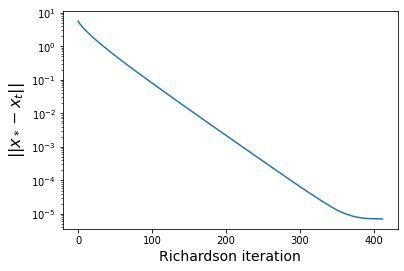

In [76]:
plt.plot(diff)
plt.yscale("log")
plt.xlabel("Richardson iteration", size=14)
plt.ylabel("$||x_* - x_t||$", size=16)
plt.savefig("Richardson_convergence.pdf", bbox_inches="tight")